### Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
import warnings
import itertools

%matplotlib inline

### Data Preprocessing

In [2]:
df = pd.read_csv(r'C:\Users\Admin\Desktop\Project\dataset\dengue08.csv')
df['date'] = pd.to_datetime(df['date'])

In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    192 non-null    datetime64[ns]
 1   cases   192 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.1 KB


date     0
cases    0
dtype: int64

In [4]:
df.set_index('date', inplace=True)

### Data Visualization

#### Time Series Plot

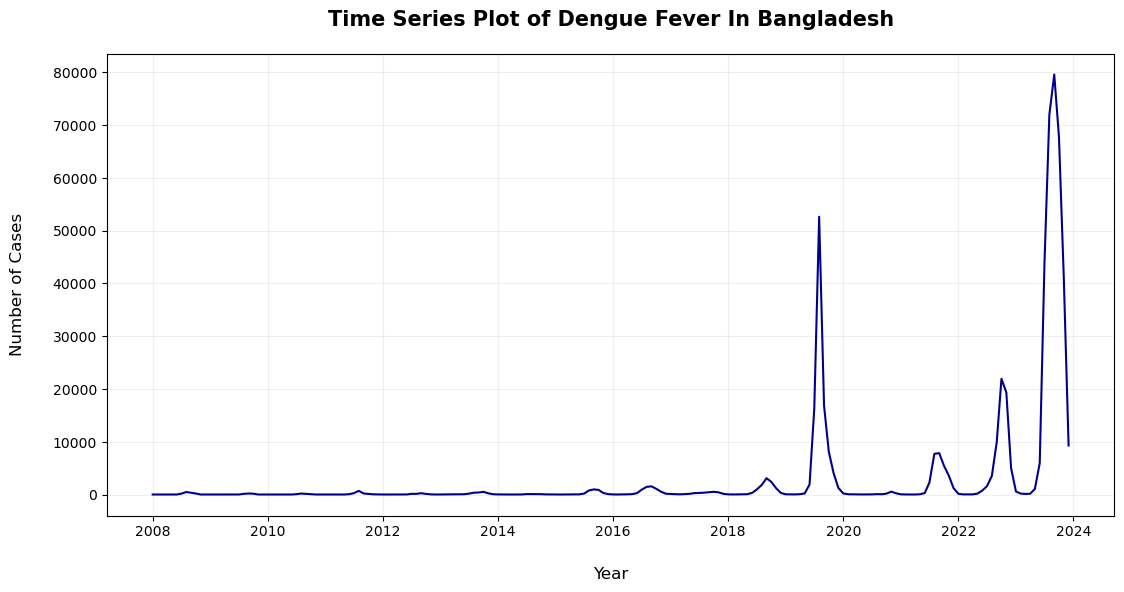

In [5]:
# Plotting using Matplotlib
plt.figure(figsize=(13, 6))
plt.plot(df.index, df['cases'], label='Number of Cases', color='darkblue')
plt.title('Time Series Plot of Dengue Fever In Bangladesh', 
          fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12, labelpad=20)
plt.ylabel('Number of Cases', fontsize=12, labelpad=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10) 
plt.grid(True, alpha=0.2)

# Save the plot to a file if needed
plt.savefig("001.time_series_plot.png", bbox_inches='tight')

plt.show()



#### Seasonal Decomposition

In [7]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")

plt.rc("figure", figsize=(12, 8))
plt.rc("font", size=11)

from statsmodels.tsa.seasonal import seasonal_decompose

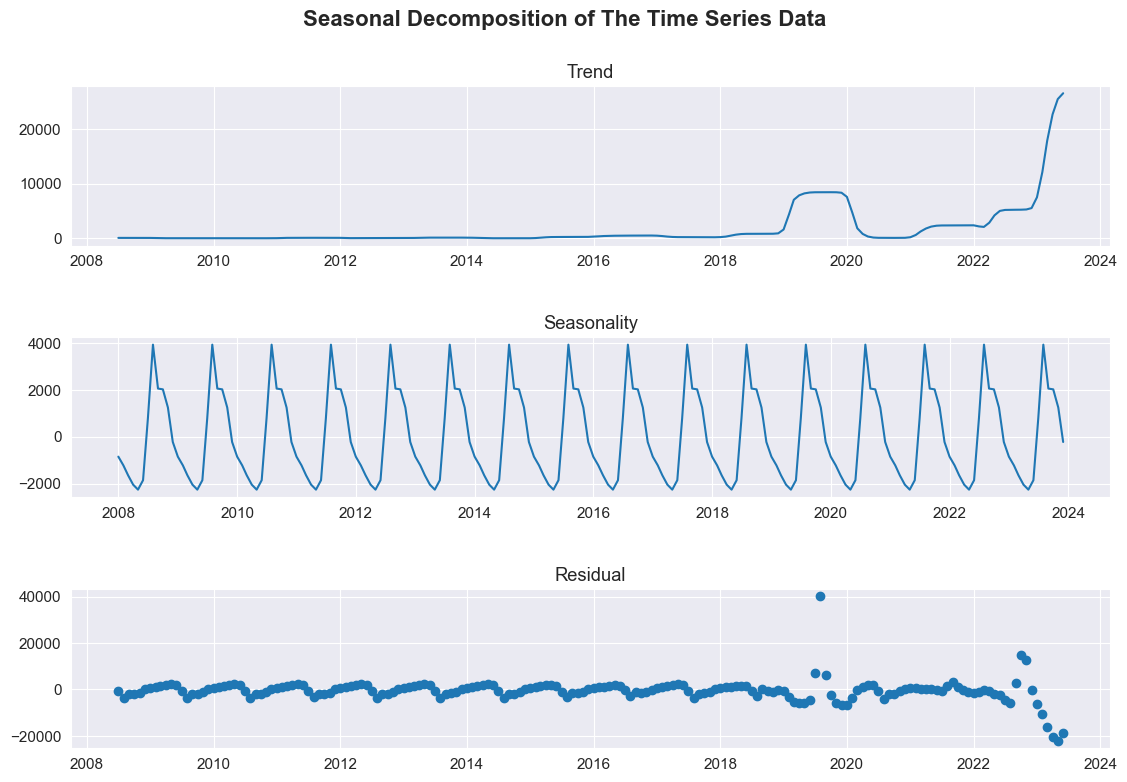

In [8]:
# Perform seasonal decomposition
result = seasonal_decompose(df)

# Plot the trend, seasonal, and residual components
plt.subplot(3, 1, 1)
plt.plot(result.trend)
plt.title('Trend')

plt.subplot(3, 1, 2)
plt.plot(result.seasonal)
plt.title('Seasonality')

plt.subplot(3, 1, 3)
plt.scatter(df.index, result.resid)  # Use scatter for residuals
plt.title('Residual')

# Add some whitespace between the subplots
plt.tight_layout(pad=3.0) 

# Add a title to the entire plot
plt.suptitle('Seasonal Decomposition of The Time Series Data', fontsize=16, y=1.01, fontweight='bold')

# Save the plot to a file
plt.savefig("002.seasonal_decomposition_components.png", bbox_inches='tight')

#### ACF, PACF Plot
##### Order "p, P" of the AR term --> PACF plot
##### Order "q, Q" of the MA term --> ACF plot

In [12]:
plt.rcParams.update({'font.size': 11})

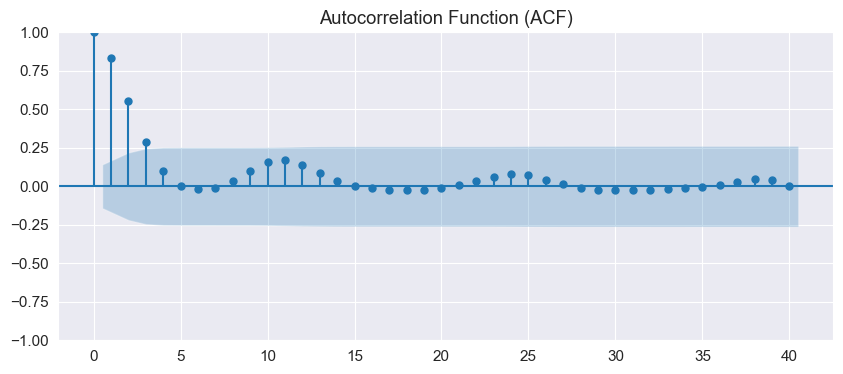

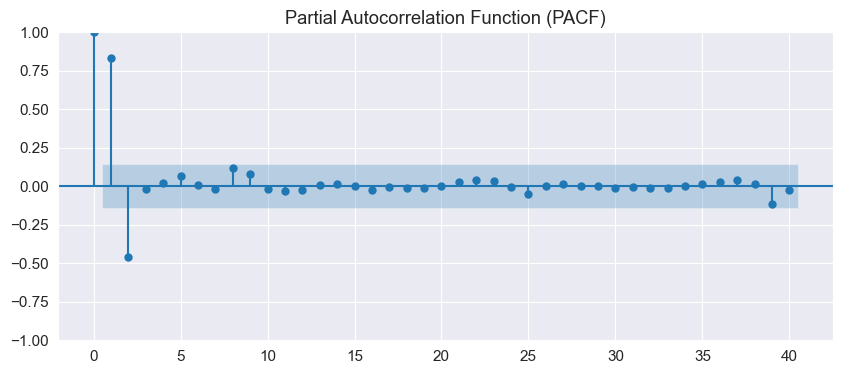

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the ACF `
plt.figure(figsize=(10, 4))
plot_acf(df['cases'], lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.savefig("003.acf.png", bbox_inches='tight')

plt.show()

# Plotting the PACF
plt.figure(figsize=(10, 4))
plot_pacf(df['cases'], lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

# Save the plot to a file
plt.savefig("003.pacf.png", bbox_inches='tight')
plt.show()




### Manual Sarima from plots and differencing

#### ADF test for stationarity

In [14]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")
        
adf_test(df['cases'])

df['first_diff'] = df['cases'] - df['cases'].shift(1)
adf_test(df['first_diff'].dropna())

df['twelve_diff'] = df['cases'] - df['cases'].shift(12)
adf_test(df['twelve_diff'].dropna())

ADF Statistics: -0.3217645427061144
p- value: 0.9223647576570452
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary
ADF Statistics: -9.220142019792085
p- value: 1.789122394227551e-15
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
ADF Statistics: -1.8180096177066778
p- value: 0.3715577834755799
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


##### Order "d" of the I term --> 1st differencing make the data stationary
##### Order "D" of the I term --> 0


#### SARIMAX from initial parameter selection

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set the frequency of the DateTime index
df.index.freq = 'MS'

# Fit the SARIMAX model
model = SARIMAX(df['cases'], order=(2, 1, 2), seasonal_order=(0, 0, 0, 12), freq="MS")
results = model.fit()

# Display the model summary, and AIC
print(results.summary())
print(f"AIC: {results.aic}")

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  192
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1906.057
Date:                Tue, 02 Jan 2024   AIC                           3822.114
Time:                        13:18:44   BIC                           3838.375
Sample:                    01-01-2008   HQIC                          3828.701
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6326      0.100     16.325      0.000       1.437       1.829
ar.L2         -0.9475      0.059    -16.106      0.000      -1.063      -0.832
ma.L1         -1.5076      0.118    -12.829      0.0

In [25]:
#Calculate MAE
from sklearn.metrics import mean_absolute_error
in_sample_preds = results.get_prediction(start=pd.to_datetime('2008-01-01'), dynamic=False)
y_true = df['cases']
y_pred = in_sample_preds.predicted_mean
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

#Calculate RMSE

from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')


MAE: 1512.306413730557
RMSE: 5175.977471576012


In [17]:
# Step 3: Visualize the actual vs predicted values along with the forecast for 2024
forecast = results.get_forecast(steps=12)
pred_conf = forecast.conf_int()

In [18]:
# Extracting the forecasted values from the PredictionResultsWrapper object
forecasted_values = forecast.predicted_mean

# Printing the forecasted values
print(forecasted_values)


2024-01-01   -11587.629710
2024-02-01   -18802.526568
2024-03-01   -10802.708034
2024-04-01     9093.682394
2024-05-01    33997.086949
2024-06-01    55803.400934
2024-07-01    67809.428578
2024-08-01    66749.843098
2024-09-01    53644.688721
2024-10-01    33253.071553
2024-11-01    12378.275741
2024-12-01    -2381.703878
Freq: MS, Name: predicted_mean, dtype: float64


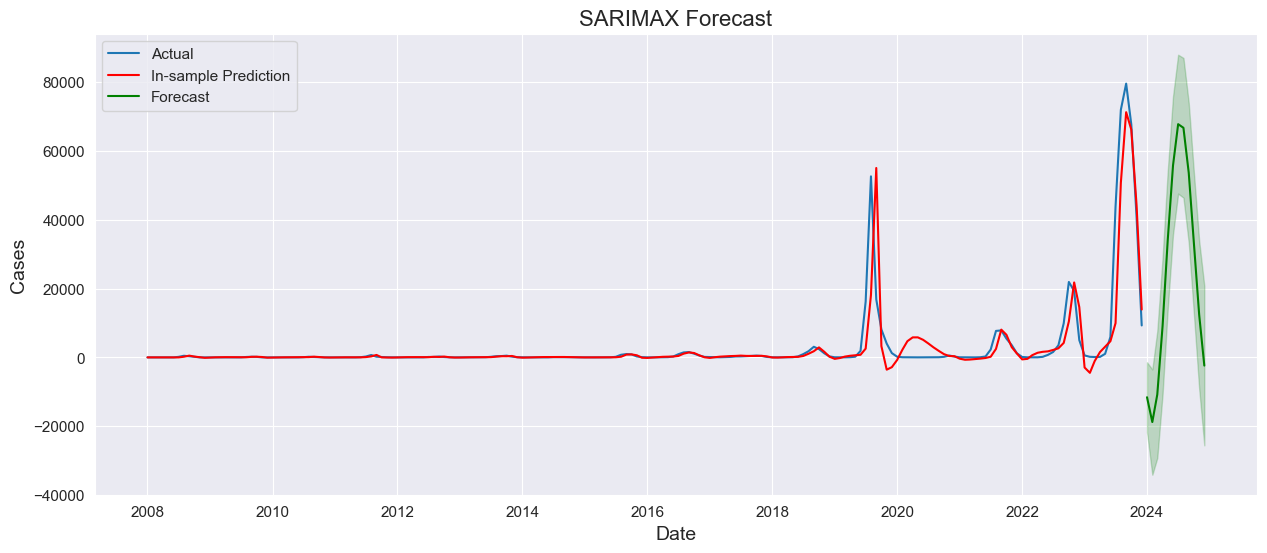

In [19]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['cases'], label='Actual')
plt.plot(y_pred.index, y_pred, label='In-sample Prediction', color='r')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='g')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='green', alpha=0.2)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cases', fontsize=14)
plt.title('SARIMAX Forecast',fontsize=16)
plt.legend(loc='upper left')

plt.savefig("004.sarima_manual_forecast.png", bbox_inches='tight')

plt.show()

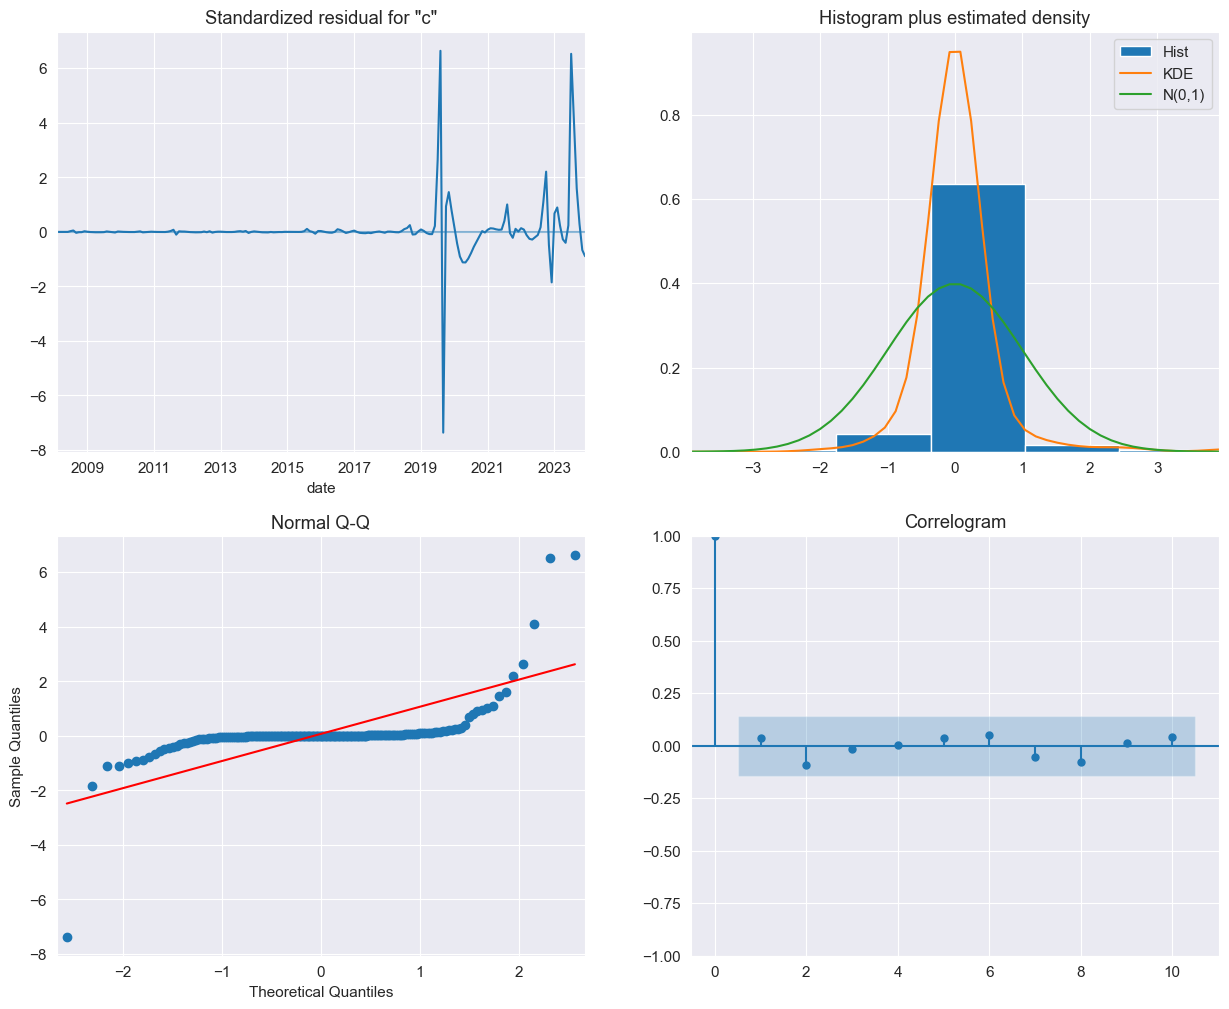

In [20]:
#Residual Analysis
results.plot_diagnostics(figsize=(15, 12))
plt.show()


In [21]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = results.resid

# Perform the Ljung-Box test
ljung_box_results = acorr_ljungbox(residuals, lags=10)

# Directly print the results
print("Ljung-Box test results:")
print(ljung_box_results)

Ljung-Box test results:
     lb_stat  lb_pvalue
1   0.284467   0.593788
2   1.856572   0.395230
3   1.900633   0.593285
4   1.901040   0.753954
5   2.148165   0.828287
6   2.677963   0.848043
7   3.289893   0.856953
8   4.513223   0.808109
9   4.536324   0.872713
10  4.872143   0.899554


The p-values are above 0.05 (chosen significance level) for all lags, suggesting that there is no significant autocorrelation in the residuals at lags 1 through 10.